In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, Input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_fscore_support
import pandas as pd
import os
import cv2
import random
import time
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()
        print("Using GPU!")
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print("No GPU found, using CPU.")

Using GPU!


In [ ]:
# Load CIFAR-10 dataset
(cifar_train_images, cifar_train_labels), (cifar_test_images, cifar_test_labels) = tf.keras.datasets.cifar10.load_data()

# Flatten label arrays
cifar_train_labels = cifar_train_labels.flatten()
cifar_test_labels = cifar_test_labels.flatten()

# Normalize pixel values
cifar_train_images = cifar_train_images.astype('float32') / 255.0
cifar_test_images = cifar_test_images.astype('float32') / 255.0

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


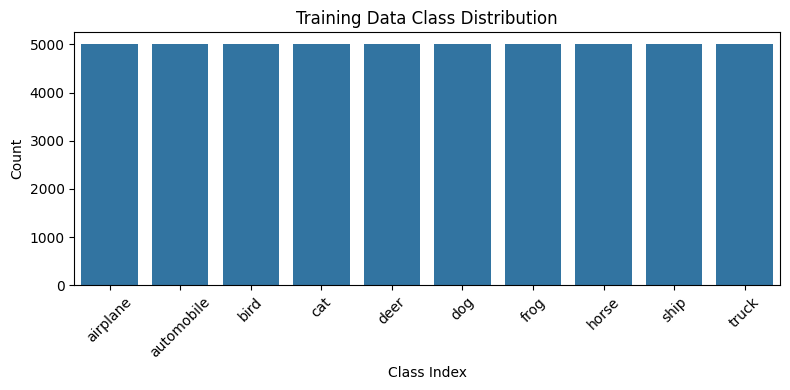

In [ ]:
# EDA: Plot class distribution
def plot_class_distribution(labels, title):
    plt.figure(figsize=(8, 4))
    sns.countplot(x=labels)
    plt.title(title)
    plt.xlabel("Class Index")
    plt.ylabel("Count")
    plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(cifar_train_labels, "Training Data Class Distribution")

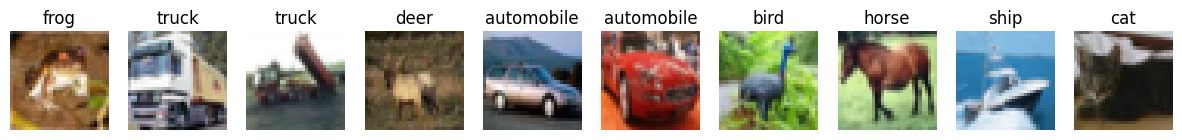

In [ ]:
# EDA: Show sample images
def show_images(images, labels, class_names, num=10):
    plt.figure(figsize=(15, 3))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

show_images(cifar_train_images, cifar_train_labels, class_names)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(cifar_train_images)

In [ ]:
# Create the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model with augmented data
history = model.fit(datagen.flow(cifar_train_images, cifar_train_labels, batch_size=64),
                    epochs=10,
                    validation_data=(cifar_test_images, cifar_test_labels))

# Save the model
model.save('DLLab4.h5')

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3182 - loss: 1.9533 - val_accuracy: 0.4999 - val_loss: 1.3509
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4961 - loss: 1.3997 - val_accuracy: 0.5858 - val_loss: 1.1842
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.5651 - loss: 1.2191 - val_accuracy: 0.6590 - val_loss: 0.9784
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6078 - loss: 1.1098 - val_accuracy: 0.6154 - val_loss: 1.1094
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6376 - loss: 1.0360 - val_accuracy: 0.6804 - val_loss: 0.9319
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.6535 - loss: 0.9950 - val_accuracy: 0.7096 - val_loss: 0.8360
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.6733 - loss: 0.9448 - val_accuracy: 0.7020 - val_loss: 0.8618
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6813 - loss: 0.9148 - 

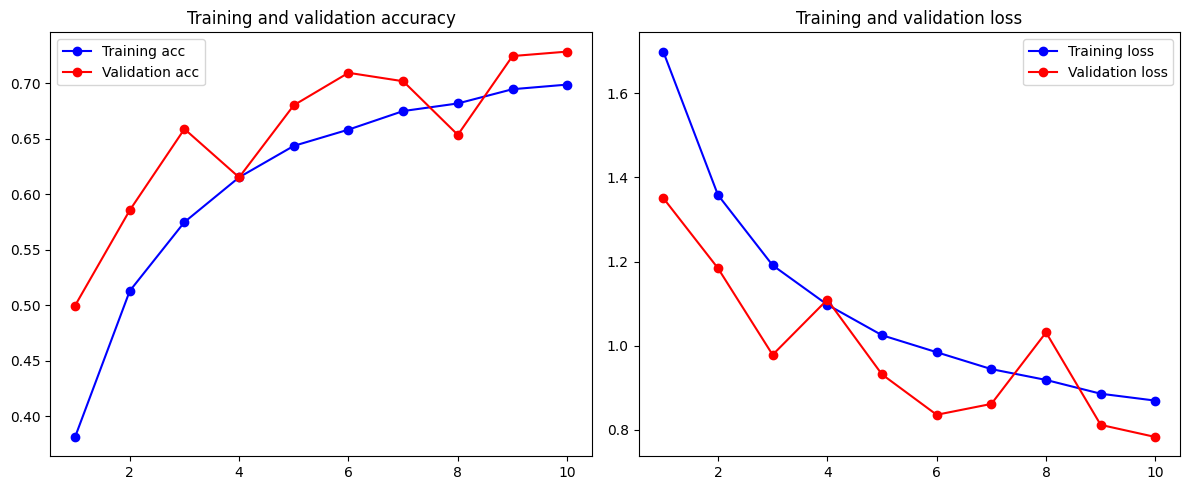

In [ ]:
# Visualization of accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


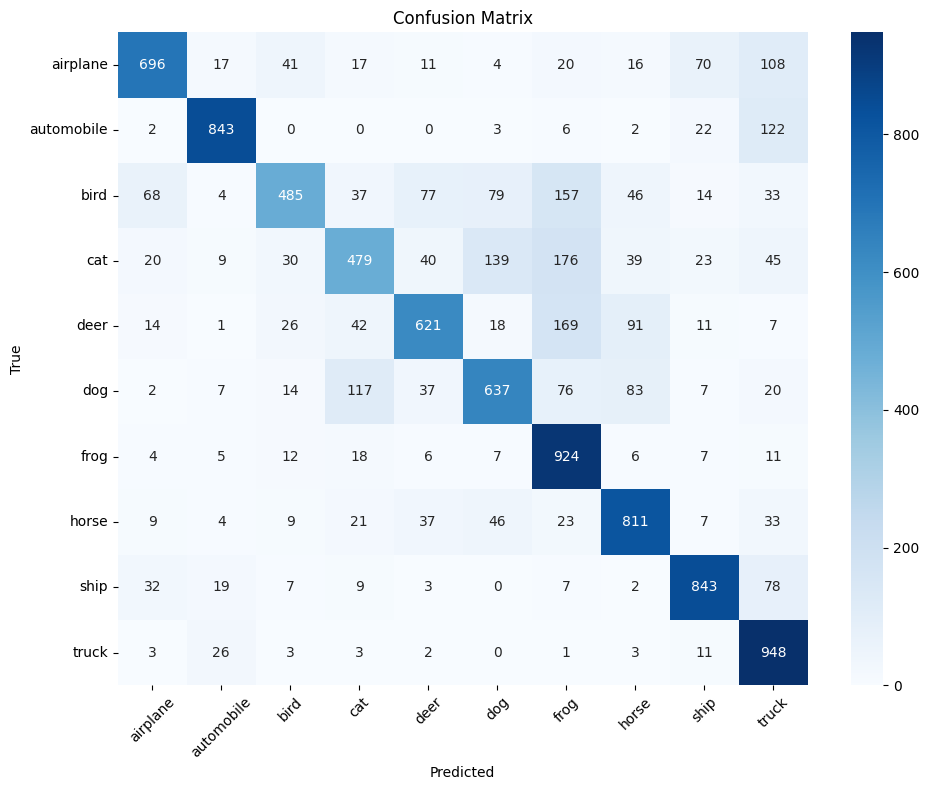

Classification Report:
              precision    recall  f1-score   support

    airplane       0.82      0.70      0.75      1000
  automobile       0.90      0.84      0.87      1000
        bird       0.77      0.48      0.60      1000
         cat       0.64      0.48      0.55      1000
        deer       0.74      0.62      0.68      1000
         dog       0.68      0.64      0.66      1000
        frog       0.59      0.92      0.72      1000
       horse       0.74      0.81      0.77      1000
        ship       0.83      0.84      0.84      1000
       truck       0.67      0.95      0.79      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.72     10000
weighted avg       0.74      0.73      0.72     10000



In [ ]:
# Get predictions on test set
test_predictions = model.predict(cifar_test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = cifar_test_labels.reshape(-1)

# Confusion Matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(test_true_classes, test_pred_classes, target_names=class_names))

In [ ]:
# Metrics Table: Accuracy, Precision, TP, TN, FP, FN
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for the entire dataset
accuracy = accuracy_score(test_true_classes, test_pred_classes)
precision = precision_score(test_true_classes, test_pred_classes, average='weighted')
recall = recall_score(test_true_classes, test_pred_classes, average='weighted')
f1 = f1_score(test_true_classes, test_pred_classes, average='weighted')

# Initialize the table for True Positives, False Positives, etc.
tp = np.diag(cm)
fp = np.sum(cm, axis=0) - tp
fn = np.sum(cm, axis=1) - tp
tn = cm.sum() - (fp + fn + tp)

# Create the DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1],
    'True Positives': [tp.sum()],
    'False Positives': [fp.sum()],
    'True Negatives': [tn.sum()],
    'False Negatives': [fn.sum()]
})

# Display the final table
print("\nPerformance Metrics Table:")
print(metrics_df)


Performance Metrics Table:
   Accuracy  Precision  Recall  F1-Score  True Positives  False Positives  \
0    0.7287   0.740189  0.7287  0.722584            7287             2713   

   True Negatives  False Negatives  
0           87287             2713  


In [ ]:
# Load the trained CIFAR-10 model
model = load_model('DLLab4.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


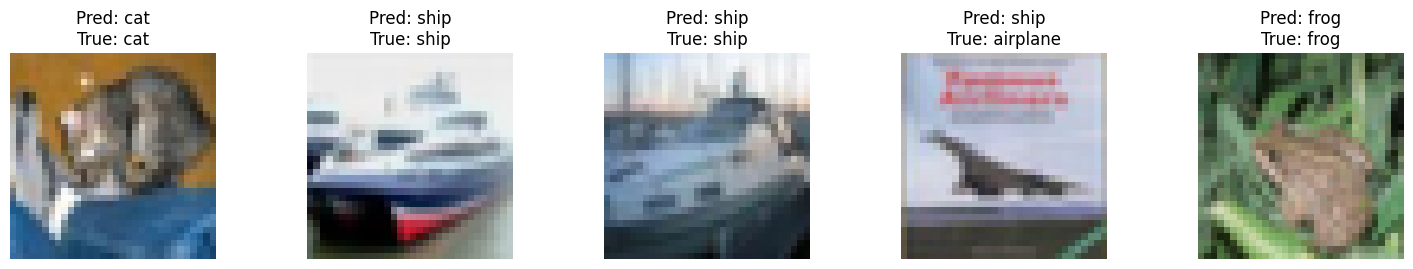

In [ ]:
# Create a figure to display images and predictions
plt.figure(figsize=(15, 5))

# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Show test images with predictions
for i in range(5):
    # Get the prediction
    pred = model.predict(cifar_test_images[i:i+1])
    predicted_class = np.argmax(pred)
    true_class = cifar_test_labels[i]

    # Display the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(cifar_test_images[i])
    plt.title(f'Pred: {class_names[predicted_class]}\nTrue: {class_names[true_class]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Test on MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

In [ ]:
# Preprocess MNIST images: Resize to 32x32 and convert to 3 channels (RGB)
def preprocess_mnist_for_cifar(images):
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    images = tf.image.resize(images, [32, 32])  # Resize to 32x32
    images = tf.image.grayscale_to_rgb(images)  # Convert to RGB
    return images.numpy().astype('float32') / 255

mnist_test_images_processed = preprocess_mnist_for_cifar(mnist_test_images)

In [ ]:
# Prediction
predictions = model.predict(mnist_test_images_processed)
mnist_pred_labels = np.argmax(predictions, axis=1)

truth = 0
for i in range(100):
    if mnist_pred_labels[i] == mnist_test_labels[i]:
        truth += 1

print(f"Accuracy on first 100 MNIST images: {truth}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy on first 100 MNIST images: 3%


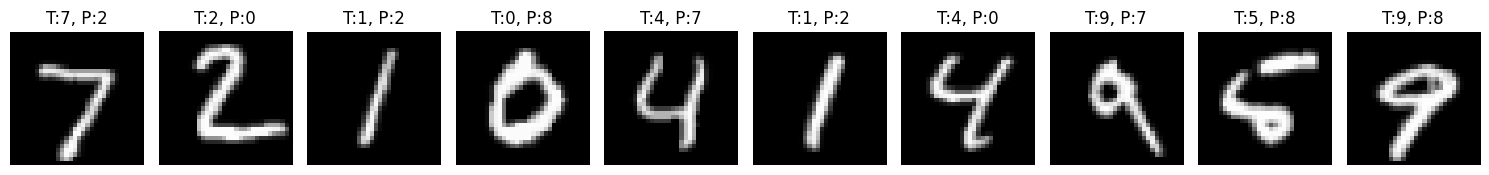

In [ ]:
# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Show a few MNIST images with predictions by the CIFAR-10 model
def show_predictions(images, true_labels, pred_labels, num=10):
    plt.figure(figsize=(15, 3))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(images[i].reshape(32, 32, 3))
        plt.title(f"T:{true_labels[i]}, P:{pred_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions(mnist_test_images_processed, mnist_test_labels, mnist_pred_labels, 10)

In [ ]:
# Classification report
print("Classification Report (MNIST true vs CIFAR-10 predicted):")
print(classification_report(mnist_test_labels, mnist_pred_labels))

Classification Report (MNIST true vs CIFAR-10 predicted):
              precision    recall  f1-score   support

           0       0.00      0.01      0.01       980
           1       0.00      0.00      0.00      1135
           2       0.14      0.19      0.16      1032
           3       0.05      0.05      0.05      1010
           4       0.00      0.00      0.00       982
           5       0.01      0.01      0.01       892
           6       0.23      0.01      0.02       958
           7       0.14      0.12      0.13      1028
           8       0.06      0.18      0.09       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.06     10000
   macro avg       0.06      0.06      0.05     10000
weighted avg       0.06      0.06      0.05     10000



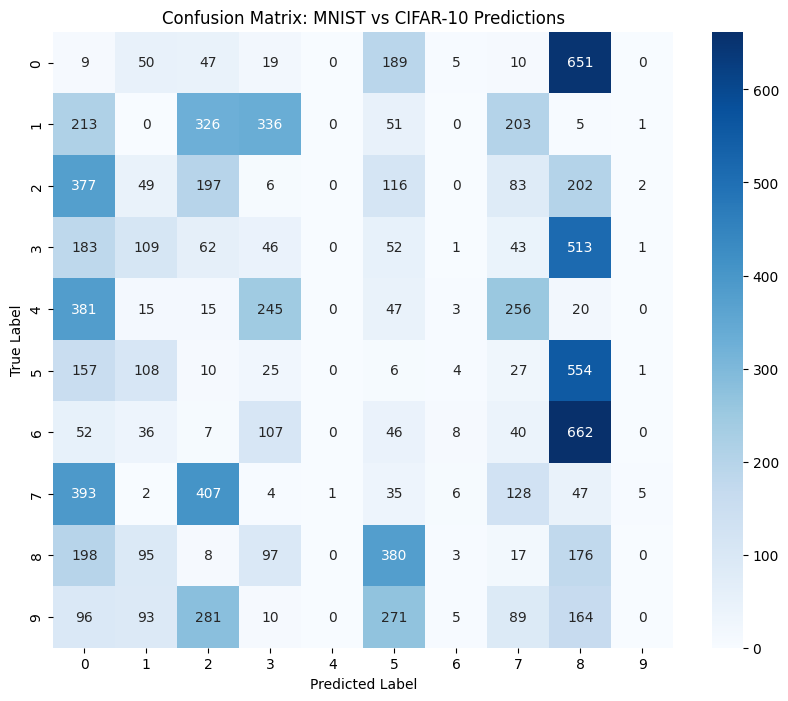

In [ ]:
# Confusion matrix
cm = confusion_matrix(mnist_test_labels, mnist_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix: MNIST vs CIFAR-10 Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()